In [10]:
using JuMP, Ipopt, Plots, Printf, LinearAlgebra, SCS, COSMO, Distributions, LightGraphs

# Calculate $N$, $n_I$, $n_t$, $n_s$, $n_p$ and all possible states and target states

In [239]:
N = 3
λ = 0.1

0.1

In [12]:
function varioussizes(N)
    ni = 4 * (N + 1)^2
    np = 5 * N + 1
    ns  = ni - 12
    nt = np + ns + 1
    return ni,np,ns,nt
end

varioussizes (generic function with 1 method)

In [13]:
ni,np,ns,nt=varioussizes(N)

(64, 16, 52, 69)

In [14]:
function statematrices(N)
    ni,np,ns,nt=varioussizes(N)
    S = Dict()
    T = [];
    TG = [];
    TB = [];
    for ua in 0:N
        for ub in 0:N
            for sa in 0:1
                for sb in 0:1
                    index = (2 * sa + sb) * (N + 1)^2 + (N + 1) * ua + ub
                    S[index] = (ua, ub, sa, sb)
                end
            end
        end
    end
    Skeyer = Dict(value => key for (key, value) in S);
    for ua in 0:N
        for ub in 0:N
            for sa in 0:1
                for sb in 0:1
                    i = (2 * sa + sb) * (N + 1)^2 + (N + 1) * ua + ub
                    if ua == N && ub == 0
                        push!(TG, i)
                        push!(T, i)
                    end
                    if ua == 0 && ub == N
                        push!(TG, i)
                        push!(T, i)
                    end
                    if ua == N && ub == N
                        push!(TB, i)
                        push!(T, i)
                    end
                end
            end
        end
    end
    Tc = [i for i in 0:ni-1 if i ∉ T];
    return S,Skeyer,T,TG,TB,Tc
end


statematrices (generic function with 1 method)

In [15]:
S,Skeyer,T,TG,TB,Tc=statematrices(N);

# Solving the Original problem using a non-linear solver


The function below finds the hitting time given a rate matrix Q and a list of target states and start states.

In [16]:
function hitting_time(Q,targetstates_good,targetstates_bad,startstates,λ)
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    T = A \ b
    for i in 1:n
        if T[i]==0 && i ∉ targetstates
            T[i]=Inf 
        end
    end
    return [T[start_state] for start_state ∈ startstates]
end

hitting_time (generic function with 1 method)

Another useful tool would be to get a function that, given rate-matrix $Q$, checks if the CTMC is irreducible or not.

In [17]:
function is_irreducible(Q::Matrix{Float64})
    n = size(Q, 1)
    G = SimpleDiGraph(n) 
    for i in 1:n
        for j in 1:n
            if i != j && Q[i, j] > 0
                add_edge!(G, i, j)
            end
        end
    end
    return is_strongly_connected(G)
end

is_irreducible (generic function with 1 method)

We try seeing if the above works for two specific small examples, and realise that it does work

In [18]:
Q = [-1.0  0.5  0.5  0.0;
      0.25 -0.5  0.0  0.25;
      1/6  0.0  -1/3  1/6;
      0.0  0.0  0.0  0.0]
println(is_irreducible(Q))
println(hitting_time(Q,[3],[],[1,2,3,4],0))

false
[2.666666666666667, 3.3333333333333335, 0.0, Inf]


In [19]:
Q = [-1.0  0.5  0.5  0.0  0.0;
      0.25 -0.75  0.25  0.25  0.0;
      0.25  0.0  -0.5  0.25  0.0;
      0.25  0.25  0.25 -0.75  0.0;
      0.0   0.0   0.0  0.0   0.0]
println(is_irreducible(Q))
println(hitting_time(Q,[4,5],[],[1,2,3],0))

false
[6.0, 5.0, 5.0]


Now we focus on our case. First we attempt to build $Q$. We do so in two ways. One is to construct it using definition. And the second is to use our 3-tensor.

In [20]:
function Q_maker(P,N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    # Q=@expression(model, zeros(AffExpr, ni, ni)) 
    Q=zeros(ni,ni)
    for (u, u_) in Iterators.product(values(S), values(S))
        if u == u_
            continue
        end
        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        tempk = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_
    
        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && ub != 0 && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 1
        elseif ua == ua_ && ub == ub_ && ua != 0 && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua 
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 1
        end
        if flag == 1
            Q[i+1, j+1] = P[tempk]
        end
    end

    for i in 1:ni
        # Calculate the sum of each row for Qi
        qi = sum(Q[i, :])
        Q[i,i] = -qi
    end
    return Q
end


Q_maker (generic function with 1 method)

In [21]:
function M_maker(N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=zeros(Int, ni, ni, np);
    for (u, u_) in Iterators.product(values(S), values(S))
        # Skip if u and u_ are the same
        if u == u_
            continue
        end

        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && ub != 0 && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 1
        elseif ua == ua_ && ub == ub_ && ua != 0 && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua 
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 1
        end

        if flag == 1
            M[i+1, j+1, tempk] = flag
        end
    end
    for k in 1:np
        # Calculate the sum of each row for the kth slice of M (equivalent to M[:,:,k] in Python)
        M_i = [sum(M[:, :, k][i, :]) for i in 1:ni]

        for u in values(S)
            i = Skeyer[u]
            M[i+1, i+1, k] = -M_i[i+1]
        end
    end
    
    return M
end


M_maker (generic function with 1 method)

In [22]:
function Q_maker_using_M(P,N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=M_maker(N::Int64,λ::Float64,S,Skeyer)
    Q = reduce((x, y) -> x + y, [P[k] * M[:, :, k] for k in 1:np])
    return Q
end

Q_maker_using_M (generic function with 1 method)

## Check that Q_makers work

We now check if the above Q_maker functions agree with each other. To do so, first, we create a random paramter vector $\mathbf{P}$

In [23]:
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]));

In [24]:
maximum(abs.(Q_maker_using_M(P,N,λ,S,Skeyer)-Q_maker(P,N,λ,S,Skeyer)))

8.881784197001252e-16

So they do agree to quite good accuracy??

Now given a random $\mathbf{P}$, let's try finding the hitting times??

Is Q irreducible? true


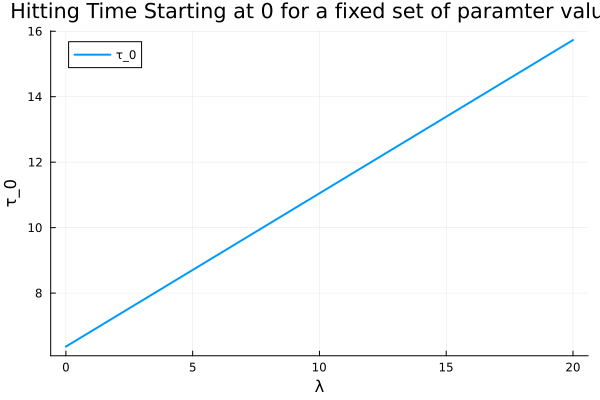

In [25]:
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
Q=Q_maker_using_M(P,N,λ,S,Skeyer)
println("Is Q irreducible? ", is_irreducible(Q))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

λ_vals = range(0.0, stop=20.0, length=100)
τ_0_values = []
for λ_ in λ_vals
    τ_curr = hitting_time(Q, targetstates_good, targetstates_bad, allstates, λ_)
    push!(τ_0_values, τ_curr[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


I am quite unsure why it is linear in $\lambda$, although I guess it makes sense

I guess this works????

## Find optimal $\mathbf{P}$ to minimise $\tau_0$

Now, we intend on trying to solve the optimisation problem in our project.
Before that, however, we should modify our functions so that we are working with AffExpr instead

In [26]:
function Q_maker_original_mod(P,N::Int64,λ::Float64, model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    Q=@expression(model, zeros(AffExpr, ni, ni)) 
    for (u, u_) in Iterators.product(values(S), values(S))
        if u == u_
            continue
        end
        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && ub != 0 && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 1
        elseif ua == ua_ && ub == ub_ && ua != 0 && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua 
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 1
        end
        if flag == 1
            Q[i+1, j+1] = P[tempk]
        end
    end
    for i in 1:ni
        # Calculate the sum of each row for Qi
        qi = sum(Q[i, :])
        Q[i,i] = -qi
    end
    return Q
end

Q_maker_original_mod (generic function with 1 method)

### Doing So directly (?)

In [27]:
function hitting_time_mod(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    model2 = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model2, "print_level", 0)
    @variable(model2, T[1:n])
    @constraint(model2, A * T == b)
    # Solve the model
    optimize!(model2)

    # Get the hitting times
    T_vals = value.(T)
    # Handle infinite hitting times for unreachable states
    for i in 1:n
        if T_vals[i]==0 && i ∉ targetstates
            T_vals[i] = Inf
        end
    end

    return [T_vals[start_state] for start_state ∈ startstates]
end

hitting_time_mod (generic function with 1 method)

In [28]:
function hitting_time_mod_give_A(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    return A
end

hitting_time_mod_give_A (generic function with 1 method)

In [29]:
function hitting_time_mod_give_b(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    return b
end

hitting_time_mod_give_b (generic function with 1 method)

Let's check if this works!

In [30]:
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_now=hitting_time_mod(Q,targetstates_good,targetstates_bad,allstates,λ,model)
println("maximum error: ",maximum(abs.(τ_actual-τ_now)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_now[1])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

maximum error: 3.552713678800501e-15
τ_0,exact: 9.527565060501667
τ_0: 9.527565060501669


In [31]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

A=hitting_time_mod_give_A(Q,targetstates_good,targetstates_bad,allstates,λ,model)
b=hitting_time_mod_give_b(Q,targetstates_good,targetstates_bad,allstates,λ,model)

n=size(Q,1)
@variable(model, τ[1:n])
@constraint(model, A * τ == b)
optimize!(model)
τ_now=value.(τ)
for i in 1:n
    if τ_now[i]==0 && i ∉ targetstates
        τ_now[i] = Inf
    end
end
τ_final=[τ_now[state] for state ∈ allstates]
τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
println("maximum error: ",maximum(abs.(τ_actual-τ_final)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_final[1])

maximum error: 3.552713678800501e-15
τ_0,exact: 9.527565060501667
τ_0: 9.527565060501669


Seems to work! So let's try finding optimal $\mathbf{P}$

In [56]:
N=6
λ=0.1
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
set_optimizer_attribute(model, "print_level", 0)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

@variable(model, 0<=P_[1:np] <= 1) 
@variable(model, τ[1:ni]) 
@objective(model, Min, τ[1])
@constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model))
for i in 1:np
    set_start_value(P_[i], 1.0)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], 1.0)   # Initial guess for τ
end  
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
tau_opt[1]

5.806476964317601

For $N=2$, the plot gives:

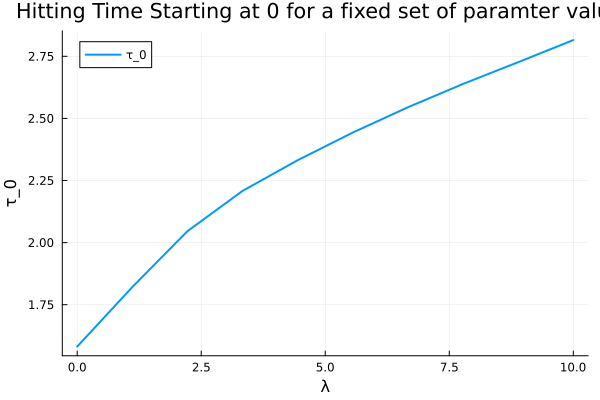

In [67]:
λ_vals = range(0.0, stop=10.0, length=10)
N=2
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 2)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


For $N=3$

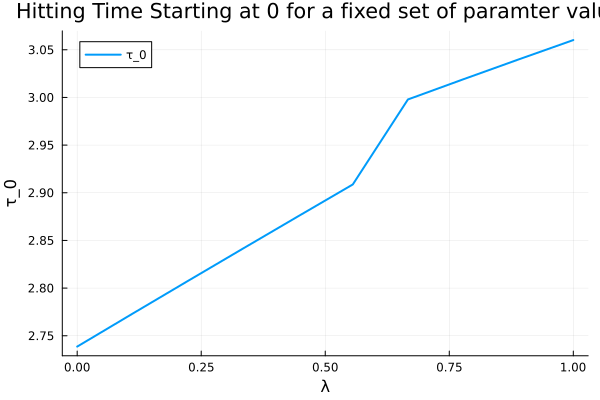

In [70]:
λ_vals = range(0.0, stop=1.0, length=10)
N=3
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 2)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


For $N=4$

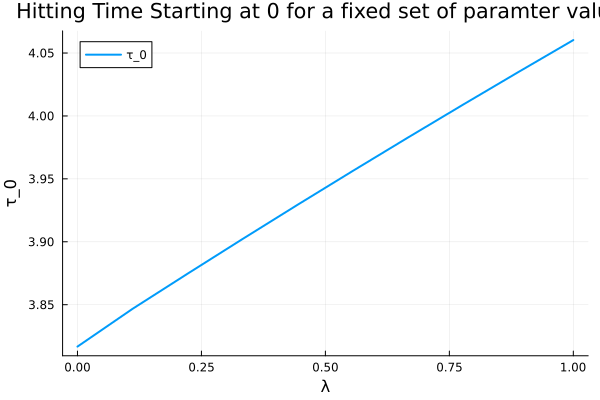

In [75]:
λ_vals = range(0.0, stop=1.0, length=10)
N=4
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 2)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


For $N=6$

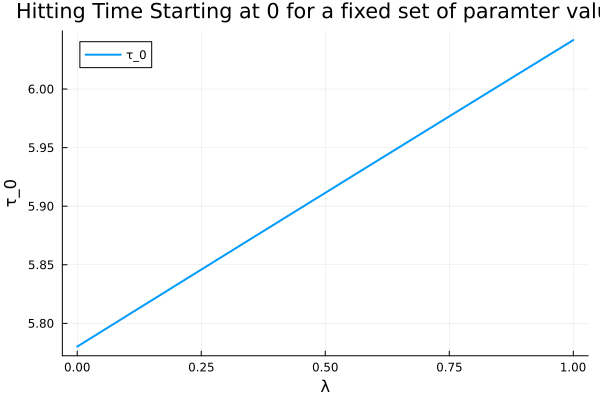

In [73]:
λ_vals = range(0.0, stop=1.0, length=10)
N=6
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 3)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


### Doing so using our matrix formulation?

In [85]:
function M_maker_mod(N::Int64,λ::Float64, model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=@expression(model, zeros(AffExpr, ni, ni, np)) 
    for (u, u_) in Iterators.product(values(S), values(S))
        # Skip if u and u_ are the same
        if u == u_
            continue
        end

        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && ub != 0 && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 1
        elseif ua == ua_ && ub == ub_ && ua != 0 && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua 
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 1
        end

        if flag == 1
            M[i+1, j+1, tempk] = flag
        end
    end
    for k in 1:np
        # Calculate the sum of each row for the kth slice of M (equivalent to M[:,:,k] in Python)
        M_i = [sum(M[:, :, k][i, :]) for i in 1:ni]

        for u in values(S)
            i = Skeyer[u]
            M[i+1, i+1, k] = -M_i[i+1]
        end
    end
    
    return M
end

M_maker_mod (generic function with 1 method)

In [86]:
function Q_maker_using_M_mod(P,N::Int64,λ::Float64,model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=M_maker_mod(N,λ,model,S,Skeyer)
    Q = reduce((x, y) -> x + y, [P[k] * M[:, :, k] for k in 1:np])
    return Q
end

Q_maker_using_M_mod (generic function with 1 method)

Next, we construct a restricted $\widetilde{M}$ and $\widetilde{Q}$


In [87]:
function Q_maker_tilde_mod(P,N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get Q
    Q=Q_maker_original_mod(P,N,λ, model,S,Skeyer)

    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end

    Qtilde = R * Q * R'
    return Qtilde
end

Q_maker_tilde_mod (generic function with 1 method)

In [197]:
function M_maker_tilde(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get M
    M=M_maker(N,λ,S,Skeyer)
    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end
    
    Mtilde=zeros(ns, ns, np)
    for k in 1:np
        Mtilde[:, :, k] = R * M[:, :, k] * R'
    end

    return Mtilde
end

M_maker_tilde (generic function with 2 methods)

In [198]:
function M_maker_tilde_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get M
    M=M_maker_mod(N,λ,model,S,Skeyer)

    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end
    Mtilde=@expression(model, zeros(AffExpr, ns, ns, np)) 
    for k in 1:np
        Mtilde[:, :, k] = R * M[:, :, k] * R'
    end

    return Mtilde
end

M_maker_tilde_mod (generic function with 1 method)

In [199]:
function Q_maker_tilde_2_mod(P,N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    return reduce((x, y) -> x + y, [P[k] * Mtilde[:, :, k] for k in 1:np])
end

Q_maker_tilde_2_mod (generic function with 1 method)

In [200]:
function A_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai = zeros(ns, np, ns)
    for i in 1:ns
        Ai[:,:,i]= Mtilde[i,:,:]   
    end
    return Ai
end

A_maker (generic function with 1 method)

In [201]:
function A_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    Ai = @expression(model, zeros(AffExpr, ns, np, ns)) 
    for i in 1:ns
        Ai[:,:,i]= Mtilde[i,:,:]   
    end
    return Ai
end

A_maker_mod (generic function with 1 method)

In [202]:
function alpha_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    alpha=zeros(np, ns)
    M=M_maker(N,λ,S,Skeyer)
    for i in 1:ns
        Si=Tc[i]
        for j in 1:ni
            for k in 1:np
                if (j-1 ∈ TB)
                    # println(i," ",Si," ",j," ",k," ", size(M), " ", size(alpha)," ", M[Si+1,j,k])
                    alpha[k,i]+=M[Si+1,j,k]
                end
                
            end
        end
    end
    return alpha
end

alpha_maker (generic function with 2 methods)

In [203]:
function alpha_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    alpha=@expression(model, zeros(AffExpr, np, ns))
    M=M_maker_mod(N,λ,model,S,Skeyer)
    for i in 1:ns
        Si=Tc[i]
        for j in 1:ni
            for k in 1:np
                if (j-1 ∈ TB)
                    # println(i," ",Si," ",j," ",k," ", size(M), " ", size(alpha)," ", M[Si+1,j,k])
                    alpha[k,i]+=M[Si+1,j,k]
                end
                
            end
        end
    end
    return alpha
end

alpha_maker_mod (generic function with 1 method)

In [204]:
N=3
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)
Q2=Q_maker_using_M_mod(P,N,λ,model,S,Skeyer)

# println(maximum(abs.(Qtilde2-Qtilde)))

τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_now=hitting_time_mod(Q2,targetstates_good,targetstates_bad,allstates,λ,model)
println("maximum error: ",maximum(abs.(τ_actual-τ_now)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_now[1])

maximum error: 2.1316282072803006e-14
τ_0,exact: 20.381218951389652
τ_0: 20.38121895138967


In [205]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)

# Qtilde=Q_maker_tilde_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
# Qtilde2=Q_maker_tilde_2_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
# Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

n=size(Q,1)
@variable(model, τ[1:ns])
for i=1:ns
    @constraint(model, 1 + τ'*Ai[:,:,i]*P + λ*alpha[:,i]'*P == 0)
end
optimize!(model)
τ_now=value.(τ)
println("τ_0: ",τ_now[1])

τ_0: 20.381218951389663


In [206]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

Qtilde=Q_maker_tilde_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
Qtilde2=Q_maker_tilde_2_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

n=size(Q,1)
@variable(model, τ[1:ns])
for i=1:ns
    @constraint(model, 1 + τ'*Ai[:,:,i]*P + λ*alpha[:,i]'*P == 0)
end
optimize!(model)
τ_now=value.(τ)
println("τ_0: ",τ_now[1])

τ_0: 20.381218951389663


So for given $P$, the matrix formulation does give the correct optimised function!

In [186]:
N=5
λ=0.5
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

@variable(model, 0<=P_[1:np] <= 1) 
@variable(model, τ[1:ni]) 
@NLobjective(model, Min, τ[1])
@constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model))
for i in 1:np
    set_start_value(P_[i], 1.0)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], 1.0)   # Initial guess for τ
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
tau_opt[1]

4.913710258425361

In [185]:
N=5
λ=0.5

model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]
alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
@variable(model, 1>=P_[1:np]>=0) 
@variable(model, τ[1:ns])
@objective(model, Min, τ[1])
for i=1:ns
    @constraint(model, τ'*Ai[:,:,i]*P_ + λ*alpha[:,i]'*P_ == -1)
end
for i in 1:np
    set_start_value(P_[i], 0.5)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], N/2)   # Initial guess for τ
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
println(tau_opt[1])

4.913710257578344


For values of $\lambda$ and $N$ where this and earlier method, both, are feasible, the optimal soln is same

$N=3$

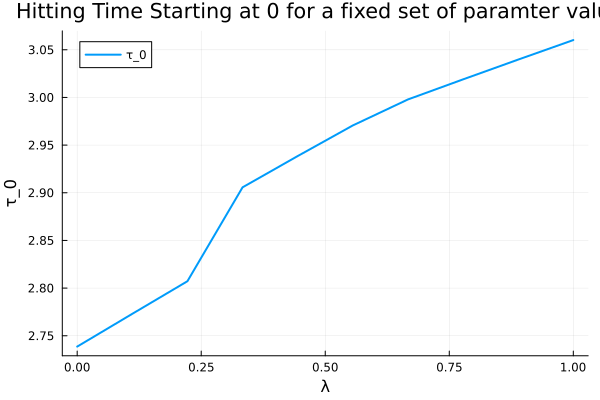

In [96]:
λ_vals = range(0.0, stop=1.0, length=10)
N=3
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], N/2)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


$N=4$

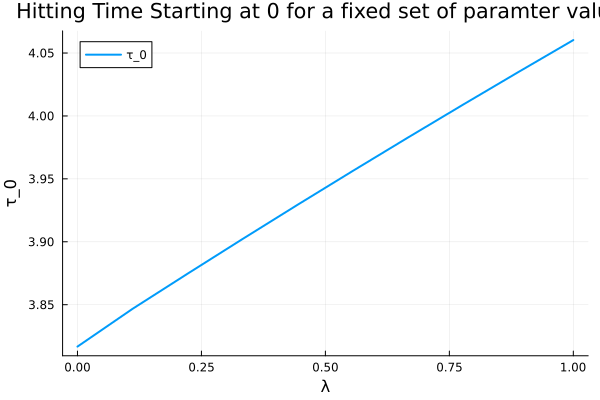

In [97]:
λ_vals = range(0.0, stop=1.0, length=10)
N=4
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], N/2)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


$N=5$

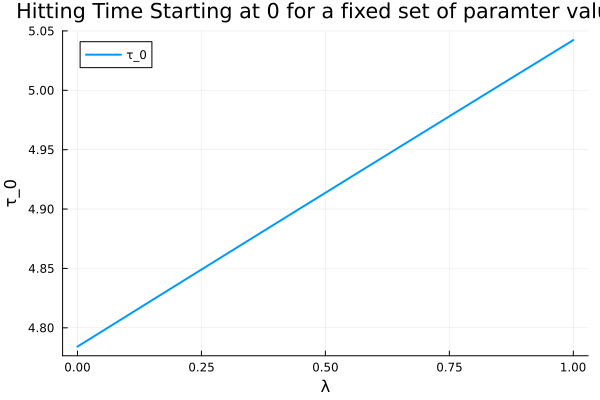

In [98]:
λ_vals = range(0.0, stop=1.0, length=10)
N=5
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], N/2)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


$N=6$

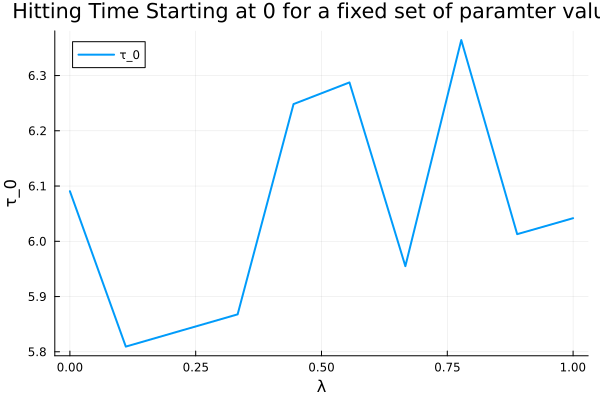

In [99]:
λ_vals = range(0.0, stop=1.0, length=10)
N=6
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], N/2)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    push!(τ_0_values, tau_opt[1])
end
plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)


# Use the matrix formulation to solve the QCQP - SDR

In [207]:
function D_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Di=zeros(nt, nt, ns)

    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:ns
        Di[np+1:np+ns,1:np,i]=Ai[:,:,i]
        Di[1:np,nt,i]=λ*alpha[:,i]'
        Di[nt,nt,i]=1
    end
    D_i=copy(Di)
    for i in 1:ns
        D_i[ :, :,i] = (Di[ :, :,i] + Di[ :, :,i]') / 2
    end
    return D_i
end

D_maker (generic function with 1 method)

In [208]:
function D_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Di=@expression(model, zeros(AffExpr, nt, nt, ns))

    Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:ns
        Di[np+1:np+ns,1:np,i]=Ai[:,:,i]
        Di[1:np,nt,i]=λ*alpha[:,i]'
        Di[nt,nt,i]=1
    end
    D_i=copy(Di)
    for i in 1:ns
        D_i[ :, :,i] = (Di[ :, :,i] + Di[ :, :,i]') / 2
    end
    return D_i
end

D_maker_mod (generic function with 1 method)

In [209]:
function E_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Ei=zeros(nt, nt, nt)

    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:nt
        Ei[i,nt,i]=1
    end
    
    E_i=copy(Ei)
    
    for i in 1:nt
        E_i[ :, :,i] = (Ei[ :, :,i] + Ei[ :, :,i]') / 2
    end
    return E_i
end

E_maker (generic function with 1 method)

In [210]:
function E_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Ei=@expression(model, zeros(AffExpr, nt, nt, nt))

    Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:nt
        Ei[i,nt,i]=1
    end
    
    E_i=copy(Ei)
    
    for i in 1:nt
        E_i[ :, :,i] = (Ei[ :, :,i] + Ei[ :, :,i]') / 2
    end
    return E_i
end

E_maker_mod (generic function with 1 method)

In [211]:
function C_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    C_i=zeros(nt, nt, np)
    
    for i in 1:np
        C_i[i,i,i]=1
    end
    return C_i
end

C_maker (generic function with 1 method)

In [212]:
function C_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    C_i=@expression(model, zeros(AffExpr, nt, nt, np))
    
    for i in 1:np
        C_i[i,i,i]=1
    end
    return C_i
end

C_maker_mod (generic function with 1 method)

Now we try to implement the SDR scheme

But before that, let's try finding the upper (optimal) bound

In [213]:
N=3
λ=0.5

model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

@variable(model, 1>=P_[1:np]>=0) 
@variable(model, τ[1:ns])
@objective(model, Min, τ[1])
for i=1:ns
    @constraint(model, τ'*Ai[:,:,i]*P_ + λ*alpha[:,i]'*P_ == -1)
end
for i in 1:np
    set_start_value(P_[i], 1.0)  
end

for i in 1:ns
    set_start_value(τ[i], N/2)   
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
println(tau_opt[1])

2.9546891900326764


In [231]:
N=3
λ=1.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], PSD)
@objective(model, Min, tr(X * S0))

for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:nt
    @constraint(model, tr(X * Ei[:,:,i]) >= 0)
end

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 2415, constraints m: 2552
cones: 	  z: primal zero / dual free vars: 52
	  l: linear vars: 85
	  s: psd vars: 2415, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 3031, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 7.06e+00  4.99e-01  7.06e+00 -3.53e+00  1.00e-01  5.93e-03 
    25| 5.80e-06  4.

In [237]:
L=cholesky(solution).L #cholesky decomposition solution = X = vv^T
v_recov = L[:, 1] #v

69×69 LowerTriangular{Float64, Matrix{Float64}}:
  0.848779       ⋅             ⋅          …    ⋅           ⋅           ⋅ 
 -0.114965      0.828309       ⋅               ⋅           ⋅           ⋅ 
 -0.00841187   -0.16442       0.805002         ⋅           ⋅           ⋅ 
 -0.00119172   -0.00165746    0.022045         ⋅           ⋅           ⋅ 
 -0.00125737    0.000310948   0.00292982       ⋅           ⋅           ⋅ 
  0.00356172    0.000968489  -0.0136227   …    ⋅           ⋅           ⋅ 
 -0.267208      0.102802      0.0111268        ⋅           ⋅           ⋅ 
  0.128983     -0.3353        0.115036         ⋅           ⋅           ⋅ 
  0.0463564     0.0659225    -0.164539         ⋅           ⋅           ⋅ 
 -0.00218946   -0.00440796   -0.0324303        ⋅           ⋅           ⋅ 
  0.00190322   -0.000177711  -0.00237454  …    ⋅           ⋅           ⋅ 
  0.0317244     0.00607797    0.0109733        ⋅           ⋅           ⋅ 
  0.000900548  -0.00447561   -0.029471         ⋅           ⋅   